# Evaluating Five Time Series Methods to Predict Stock Prices: A Comprehensive Comparison¶

Here are four distinct time series methods for predicting next-day stock prices in Python. Each method offers unique strengths, and the choice of technique should be guided by the characteristics of the data and the forecasting objective:



## 1. ARIMA (AutoRegressive Integrated Moving Average)


A classical statistical model effective for univariate time series data exhibiting stationarity or trends. ARIMA is well-suited for modeling linear relationships and capturing short-term dependencies in stock prices.
- AR(AutoRegressive): Uses the dependency between an observation and several lagged observations.
- I(Integrated): Differencing the data to make it stationary.
- MA(Moving Average): Uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

## 2. ETS (Exponential Smoothing)
A smoothing technique that models level, trend, and seasonality in data. It is particularly useful when the data exhibits consistent seasonal patterns, providing robust predictions for time series with cyclical or irregular fluctuations.

## 3. LSTM (Long Short-Term Memory Networks)
A type of recurrent neural network (RNN) that excels in capturing long-term dependencies in sequential data. LSTM is ideal for modeling stock prices with complex, nonlinear relationships and can identify temporal patterns that traditional methods might miss.

## 4. Facebook Prophet
A forecasting tool developed by Facebook, designed for time series data with strong seasonal effects and holidays. Prophet is highly flexible and can accommodate non-linear trends and external factors, making it a good choice for stock prices influenced by market events or seasonal patterns.

## 5. Random Forest Regression
An ensemble learning method based on decision trees, Random Forest can be adapted for time series forecasting by using lagged features and external variables as inputs. It is particularly useful for modeling non-linear relationships and capturing interactions between different predictors, providing robust forecasts even with noisy data.

To evaluate the performance of each forecasting model, we will calculate the **forecast error**, using metrics:

1. **Mean Absolute Error (MAE)**: The average of the absolute differences between the predicted and actual values.
2. **Mean Squared Error (MSE)**: The average of the squared differences between the predicted and actual values.
3. **Root Mean Squared Error (RMSE)**: The square root of the MSE, which gives a more interpretable error metric by bringing it back to the original units of the data.
4. **Mean Absolute Percentage Error (MAPE)**: The percentage difference between the predicted and actual values.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor


In [2]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("cmdstanpy").disabled = True

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

In [4]:
df = pd.read_csv('stock_prices.csv', index_col='Date', parse_dates=True)
symbols = df['Symbol'].unique()
results =[]

for symbol in symbols:
    print(symbol)
    df_1 = df[df['Symbol'] == symbol]

    stock_data=df_1

    # Split data into training and test sets (e.g., 95% train, 5% test)
    train_size = int(len(stock_data) * 0.95)
    train, test = stock_data['Close'][:train_size], stock_data['Close'][train_size:]

    # Fit ARIMA model
    model = ARIMA(train, order=(5,1,0))
    model_fit = model.fit()

    # Forecast the test data (next day's price)
    forecast = model_fit.forecast(steps=len(test))

    # Calculate forecast errors
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test, forecast)

    #print(f"ARIMA - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%")
    results.append({'symbol': symbol,
                   'model': 'ARIMA',
                   'MAE': mae,
                   'MSE': mse,
                   'RMSE': rmse,
                   'MAPE': mape})


    # Fit Exponential Smoothing model
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=5)
    model_fit = model.fit()

    # Forecast the test data (next day's price)
    forecast = model_fit.forecast(steps=len(test))

    # Calculate forecast errors
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test, forecast)

    #print(f"ETS - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%")

    results.append({'symbol': symbol,
                   'model': 'ETS',
                   'MAE': mae,
                   'MSE': mse,
                   'RMSE': rmse,
                   'MAPE': mape})

    stock_data=df_1
    # Prepare data (train-test split)
    train_size = int(len(stock_data) * 0.95)
    train_data = stock_data['Close'][:train_size].values.reshape(-1, 1)
    test_data = stock_data['Close'][train_size:].values.reshape(-1, 1)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    # Create dataset for LSTM
    def create_dataset(data, time_step=60):
        X, y = [], []
        for i in range(len(data) - time_step - 1):
            X.append(data[i:(i + time_step), 0])
            y.append(data[i + time_step, 0])
        return np.array(X), np.array(y)

    X_train, y_train = create_dataset(train_data_scaled)
    X_test, y_test = create_dataset(test_data_scaled)

    # Reshape input to be 3D for LSTM [samples, time_steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the LSTM model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Predict the next day's price
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_tt = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calculate forecast errors
    mae = mean_absolute_error(y_tt, predictions)
    mse = mean_squared_error(y_tt, predictions)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_tt, predictions)

    #print(f"LSTM - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%")
    results.append({'symbol': symbol,
                   'model': 'LSTM',
                   'MAE': mae,
                   'MSE': mse,
                   'RMSE': rmse,
                   'MAPE': mape})


    stock_data=df_1
        # Prepare data for Prophet
    stock_data = stock_data[['Close']].reset_index()
    stock_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

    # Split into train and test sets
    train_size = int(len(stock_data) * 0.95)
    train, test = stock_data[:train_size], stock_data[train_size:]

    # Initialize and fit Prophet model
    model = Prophet( daily_seasonality=True)
    model.fit(train)

    # Make predictions
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)

    # Extract predicted values
    predictions = forecast['yhat'][-len(test):].values

    # Calculate forecast errors
    mae = mean_absolute_error(test['y'], predictions)
    mse = mean_squared_error(test['y'], predictions)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test['y'], predictions)

    #print(f"Prophet - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%")
    results.append({'symbol': symbol,
                   'model': 'Prophet',
                   'MAE': mae,
                   'MSE': mse,
                   'RMSE': rmse,
                   'MAPE': mape})

    stock_data = df_1

    # Create lagged features (e.g., previous day's price)
    stock_data['Lag1'] = stock_data['Close'].shift(1)
    stock_data['Lag2'] = stock_data['Close'].shift(2)

    # Drop missing values
    stock_data.dropna(inplace=True)

    # Split data into training and test sets
    train_size = int(len(stock_data) * 0.95)
    train, test = stock_data[:train_size], stock_data[train_size:]

    # Features and target
    X_train = train[['Lag1', 'Lag2']]
    y_train = train['Close']
    X_test = test[['Lag1', 'Lag2']]
    y_test = test['Close']

    # Fit Random Forest model
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train, y_train)

    # Predict the next day's price
    predictions = model.predict(X_test)

    # Calculate forecast errors
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, predictions)

    #print(f"Random Forest - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}%")
    results.append({'symbol': symbol,
                   'model': 'Random Forest',
                   'MAE': mae,
                   'MSE': mse,
                   'RMSE': rmse,
                   'MAPE': mape})


final_results = pd.DataFrame(results)
final_results

AMT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
ORCL
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
MSFT
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
AMX
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
AAPL


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
GOOGL


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
AMZN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
BA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
EXPE
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
EA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


,symbol,model,MAE,MSE,RMSE,MAPE
0,AMT,ARIMA,26.119598,1009.541981,31.773290,0.129314
1,AMT,ETS,26.159726,1014.537781,31.851810,0.129458
2,AMT,LSTM,3.557587,12.704562,3.564346,0.016400
3,AMT,Prophet,38.271175,2011.711770,44.852110,0.191048
4,AMT,Random Forest,2.455209,10.472707,3.236156,0.013256
5,ORCL,ARIMA,4.849946,35.929386,5.994113,0.043412
6,ORCL,ETS,4.672213,28.021637,5.293547,0.042430
7,ORCL,LSTM,1.415157,2.024180,1.422737,0.013337
8,ORCL,Prophet,16.523417,307.287024,17.529604,0.153741
9,ORCL,Random Forest,1.833516,7.306985,2.703144,0.017115


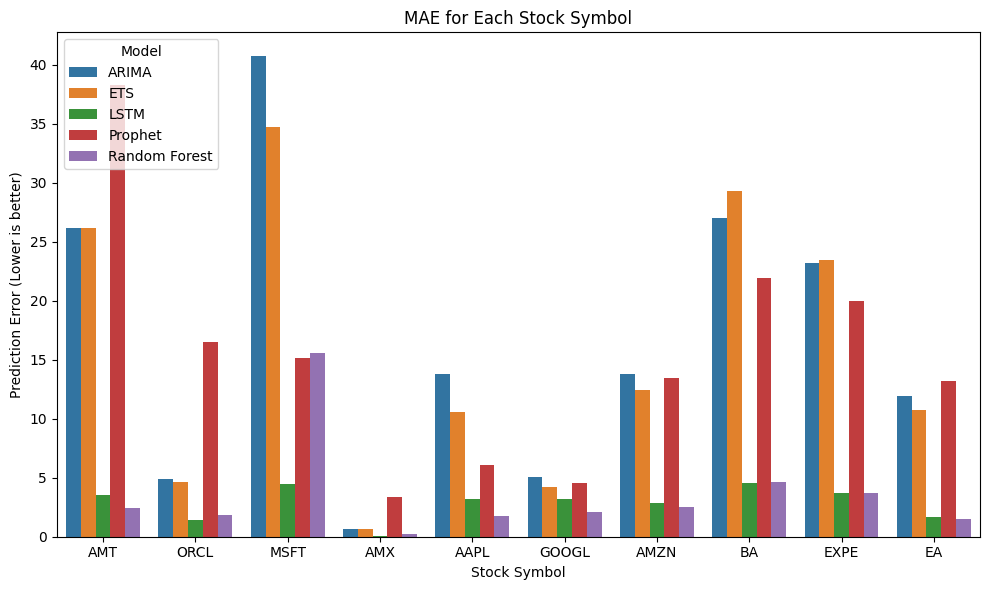

In [5]:
# Create a grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='symbol', y='MAE', hue='model', data=final_results)

# Adding labels and title
plt.title('MAE for Each Stock Symbol')
plt.xlabel('Stock Symbol')
plt.ylabel('Prediction Error (Lower is better)')
plt.legend(title='Model', loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

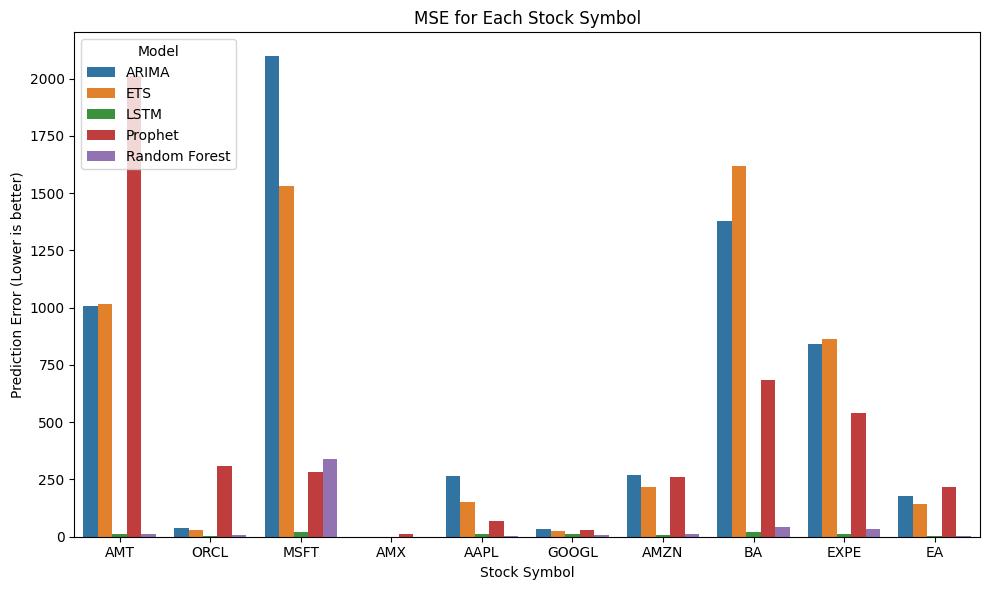

In [6]:
# Create a grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='symbol', y='MSE', hue='model', data=final_results)

# Adding labels and title
plt.title('MSE for Each Stock Symbol')
plt.xlabel('Stock Symbol')
plt.ylabel('Prediction Error (Lower is better)')
plt.legend(title='Model', loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

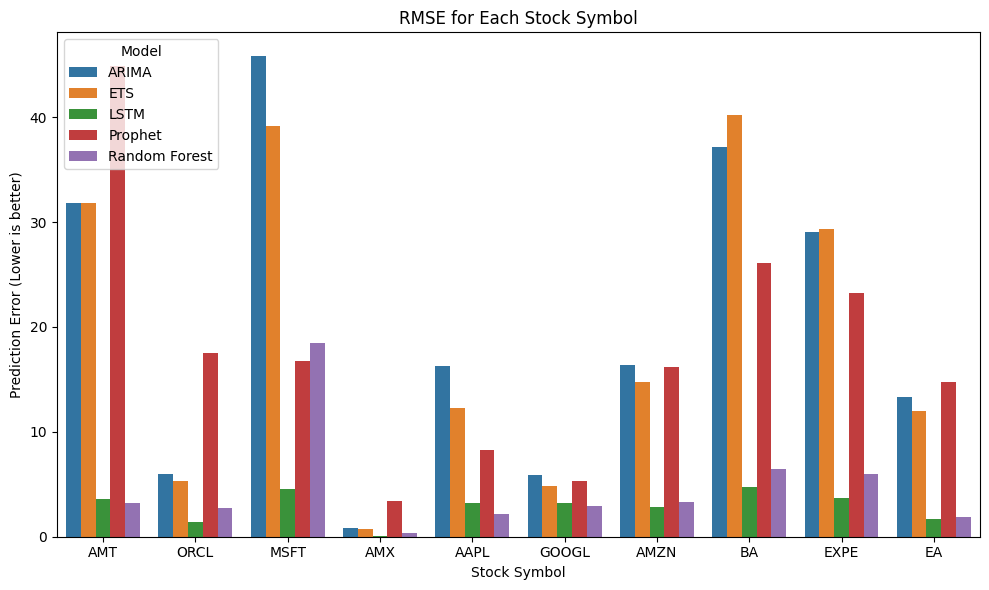

In [7]:
# Create a grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='symbol', y='RMSE', hue='model', data=final_results)

# Adding labels and title
plt.title('RMSE for Each Stock Symbol')
plt.xlabel('Stock Symbol')
plt.ylabel('Prediction Error (Lower is better)')
plt.legend(title='Model', loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

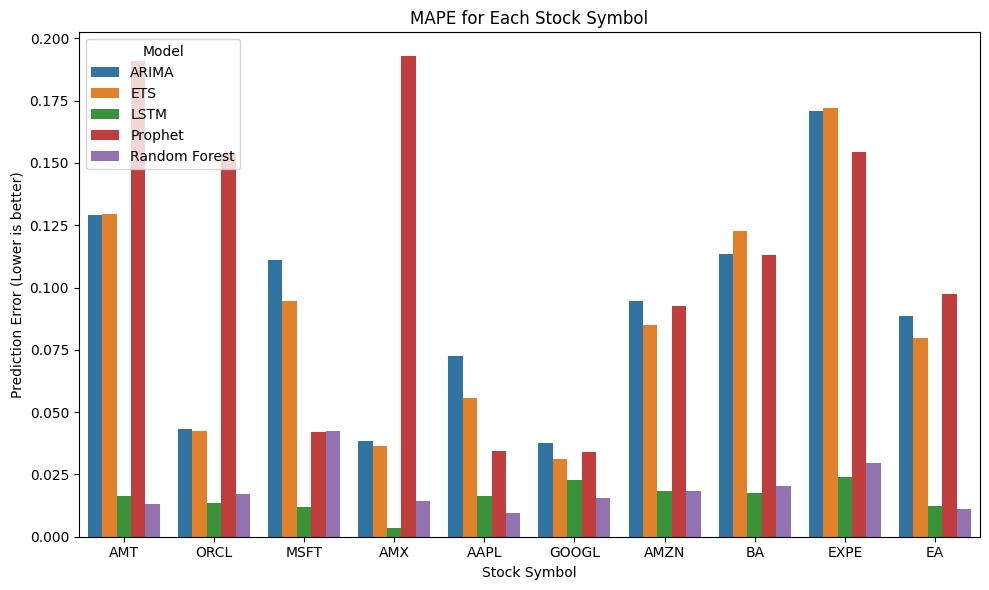

In [8]:
# Create a grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='symbol', y='MAPE', hue='model', data=final_results)

# Adding labels and title
plt.title('MAPE for Each Stock Symbol')
plt.xlabel('Stock Symbol')
plt.ylabel('Prediction Error (Lower is better)')
plt.legend(title='Model', loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# Hyperparameter Tuning for ARIMA using Grid Search

### Since we have only used the models with default hyperparameters so far, the final results may vary once hyperparameter tuning is applied. Given that the ARIMA model performed suboptimally, I will focus on optimizing its hyperparameters to assess whether this improves its performance relative to the other models.

In [9]:
logging.getLogger("cmdstanpy").disabled = False

In [10]:
new_results = []
for symbol in symbols:
    print(symbol)
    df_1 = df[df['Symbol'] == symbol]

    stock_data=df_1

    train_size = int(len(stock_data) * 0.95)
    train, test = stock_data['Close'][:train_size], stock_data['Close'][train_size:]
    # Define the range for p, d, q
    p = range(0, 6)  # AR terms
    d = range(0, 3)  # Differencing terms
    q = range(0, 6)  # MA terms

    # Create a list of all combinations of p, d, q
    parameters = list(product(p, d, q))

    # Store the results
    new_results = []

    # Loop through all combinations of (p, d, q)
    for param in parameters:
        try:
            model = ARIMA(train, order=param)
            model_fit = model.fit()

            # Get AIC and BIC values
            aic = model_fit.aic
            bic = model_fit.bic

            # Calculate the error
            forecast = model_fit.forecast(steps=len(test))
            error = mean_squared_error(test, forecast)

            new_results.append((symbol, param, aic, bic, error))
        except Exception as e:
            print(f"Error with parameters {param}: {e}")
            continue

# Convert results into a DataFrame for easy comparison
new_results_df = pd.DataFrame(new_results, columns=['symbol', 'Parameters', 'AIC', 'BIC', 'MSE'])



AMT
ORCL
MSFT
AMX
AAPL
GOOGL
AMZN
BA
EXPE
EA


In [11]:
gr_df = new_results_df.groupby('Parameters')['MSE'].mean().reset_index()

# Sort by AIC or BIC to find the best model
best_model = gr_df.loc[gr_df['MSE'].idxmin()]
#print("Best Model based on AIC:")
print(best_model)
print('------------')

Parameters    (5, 2, 0)
MSE           21.186365
Name: 102, dtype: object
------------


### Evaluate the performance of the optimized ARIMA model against the default ARIMA model and alternative forecasting models.

The optimized ARIMA model demonstrates a superior MSE score compared to the default ARIMA model. Additionally, the ARIMA(5, 2, 0) model outperforms both ETS and Prophet, a result not observed with the previously tested default ARIMA model.

In [13]:
print('Comparing with previous models:')
final_results.groupby('model')['MSE'].mean()

Comparing with previous models:


,MSE
model,
ARIMA,611.136126
ETS,559.305797
LSTM,10.255437
Prophet,441.060309
Random Forest,46.450499


# Final Results


The top-performing models based on MSE are LSTM, ARIMA with updated parameters (5, 2, 0), and Random Forest. Depending on the specific use case, one can choose to employ any combination of these models, either individually or collectively through a VotingRegressor.